Notebook per fare il Training e il Testing del modello per la classe di centralità 10-40 % per fare il confronto con i risultati dell'analisi standard. Nella prima parte del notebook Training e Testing, nella seconda viene stimata la Significance che si otterrebbe misurando lo yield. 

In [1]:
%pylab inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pickle

%run analysis_utils.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
training = False

In [3]:
from scipy.stats import norm

## Data preliminary

Carico i dati, defisco le variabili su cui fare Training e preparo il Training Set.

In [4]:
df_ML = pd.read_pickle('/home/fmazzasc/HypertritonData/df_ML.pkl')

bkg = df_ML.query('y==0')
sig = df_ML.query('y==1')

In [5]:
len(sig)

877882

In [6]:
data = pd.concat([bkg,sig],ignore_index=True)
data = data.sample(frac=1)

In [7]:
training_columns = [ 'V0CosPA','ProngsDCA', 'DistOverP','ArmenterosAlpha','NpidClustersHe3','V0pt','TPCnSigmaHe3']

In [8]:
df = data.query('10<=Centrality<=40')
traindata,testdata,ytrain,ytest = train_test_split(df, df['y'], test_size=0.5)

Plotto le variabili di Training del segnale e del fondo come confronto e la matrice delle correlazioni.

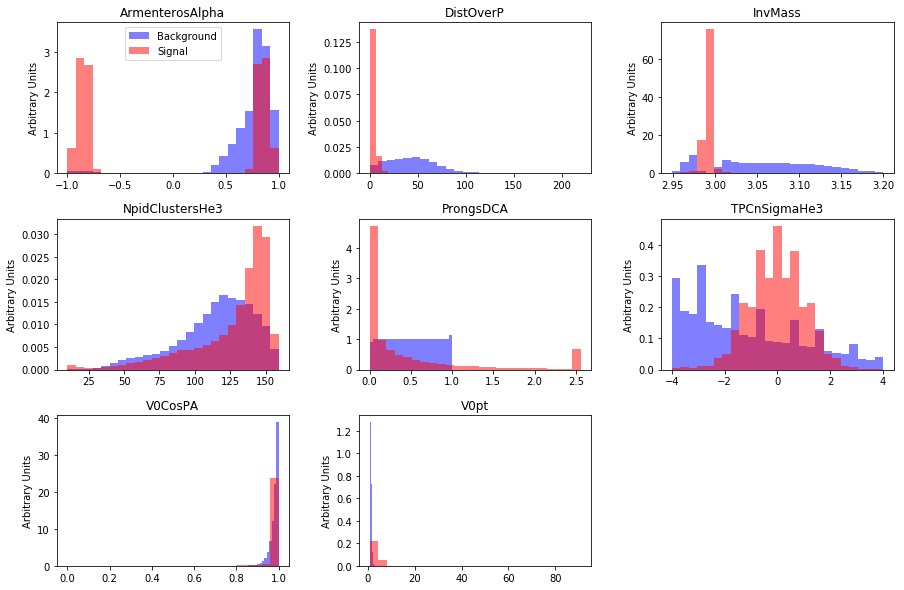

In [9]:
plot_distr(df,training_columns+['InvMass'])

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_corr(df, columns, **kwds):
    """Calculate pairwise correlation between features.
    Extra arguments are passed on to DataFrame.corr()
    """
    col=columns+['y']
    df=df[col]
    
    data_sig = df[df.y > 0.5].drop('y', 1)
    data_bkg = df[df.y < 0.5].drop('y', 1)

    corrmat_sig = data_sig.corr(**kwds)
    corrmat_bkg = data_bkg.corr(**kwds)

    t=r'$\mathrm{\ \ \ ALICE \ Simulation}$ Pb-Pb $\sqrt{s_{\mathrm{NN}}}$ = 5.02 TeV'
    fig = plt.figure(figsize=(10.7, 6.6))
    # plt.title(t,y=1.08,fontsize=16)
    plt.suptitle(t,fontsize=18,ha='center')
    grid = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad=0.15, share_all=True, cbar_location="right", cbar_mode="single", cbar_size="7%", cbar_pad=0.15)

    opts = {'cmap': plt.get_cmap("coolwarm"), 'vmin': -1, 'vmax': +1, 'snap': True}

    ax1 = grid[0]
    ax2 = grid[1]
    heatmap1 = ax1.pcolor(corrmat_sig, **opts)
    heatmap2 = ax2.pcolor(corrmat_bkg, **opts)
    ax1.set_title('Signal', fontsize=14,fontweight='bold')
    ax2.set_title('Background', fontsize=14,fontweight='bold')

    labels = corrmat_sig.columns.values
    lab = [r'$\it{M}_{\mathrm{He}^{3}\pi^{-}}$',r'n$\sigma_{\mathrm{TPC}}\ \mathrm{He}^{3}$',r'$\mathrm{V}_{0} \ p_{\mathrm{T}}\ (\mathrm{GeV}/c)$',r'n$_{cluster\ \mathrm{TPC}}\ \mathrm{He}^{3}$',r'$\alpha$-armenteros',r'L/$p$ ($\frac{cm}{\mathrm{Gev}/c}$)',r'$\mathrm{DCA}_{\mathrm{V_{0}\ tracks}} ($cm$)$',r'$\cos{(\theta_{pointing})}$']
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(lab)), minor=False)
        ax.set_yticks(np.arange(len(lab)), minor=False)
        ax.set_xticklabels(lab, minor=False, ha='left', rotation=90, fontsize=15)
        ax.set_yticklabels(lab, minor=False, va='bottom', fontsize=15)
        ax.tick_params(axis='both',which='both',direction="in")

        for tick in ax.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')

    for ax in (ax2,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(lab)), minor=False)
        ax.set_yticks(np.arange(len(lab)), minor=False)
        ax.set_xticklabels(lab, minor=False, ha='left', rotation=90, fontsize=15)
        ax.tick_params(axis='both',which='both',direction="in")

        for tick in ax.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')

    ax1.cax.colorbar(heatmap1)
    ax1.cax.toggle_label(True)

plt.tight_layout()
plt.savefig('correlations.eps', dpi=500, transparent=True)


<Figure size 432x288 with 0 Axes>

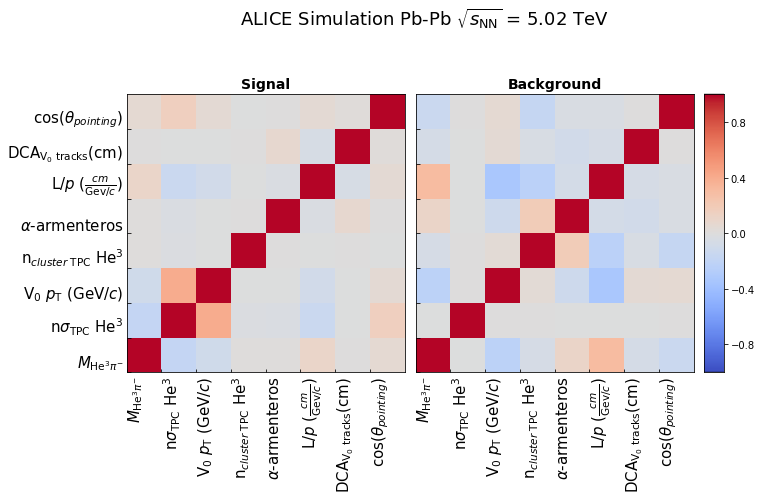

In [11]:
plot_corr(df,training_columns+['InvMass'])
plt.savefig('aaa.pdf',dpi=300,bbox_inches = "tight")

## Training

For using pre-trained models skip to the Testing part.

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params_def = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist',
    'scale_pos_weight': 10}


In [13]:
def optimize_params(dtrain,par):
    %run analysis_utils.py
    gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(2, 10, 2)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(0, 12, 2)]},
          }
    par['max_depth'],par['min_child_weight'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    
    gs_dict = {'first_par': {'name': 'subsample', 'par_values': [i/10. for i in range(4, 10)]},
           'second_par': {'name': 'colsample_bytree', 'par_values': [i/10. for i in range(8, 10)]},
          }
    par['subsample'],par['colsample_bytree'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'gamma', 'par_values': [i/10. for i in range(0, 11)]}} 
    par['gamma'],_ = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'eta', 'par_values': [0.1, 0.05, 0.01, 0.005, 0.001]}}
    par['eta'],n = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    return n

In [ ]:
dtrain = xgb.DMatrix(data=np.asarray(traindata[training_columns]), label=ytrain, feature_names=training_columns)
n_round = optimize_params(dtrain,params_def)
model_cent_integr = xgb.train(params_def, dtrain,num_boost_round=n_round) 

In [ ]:
# saving the model
pickle.dump(model_cent_integr,open("model_10_40.pkl", "wb"))

## Testing

If you skip the Training start from here.

In [14]:
if training:
    model = model_cent_integr
else:
    model = pickle.load(open("model_10_40.pkl", "rb"))

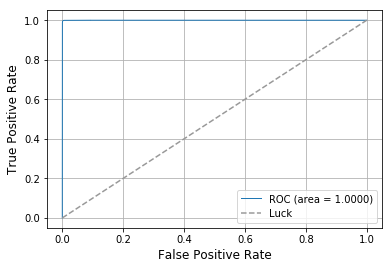

In [15]:
dtest = xgb.DMatrix(data=testdata[training_columns])
y_pred = model.predict(dtest,output_margin=True)
plot_roc(ytest,y_pred)

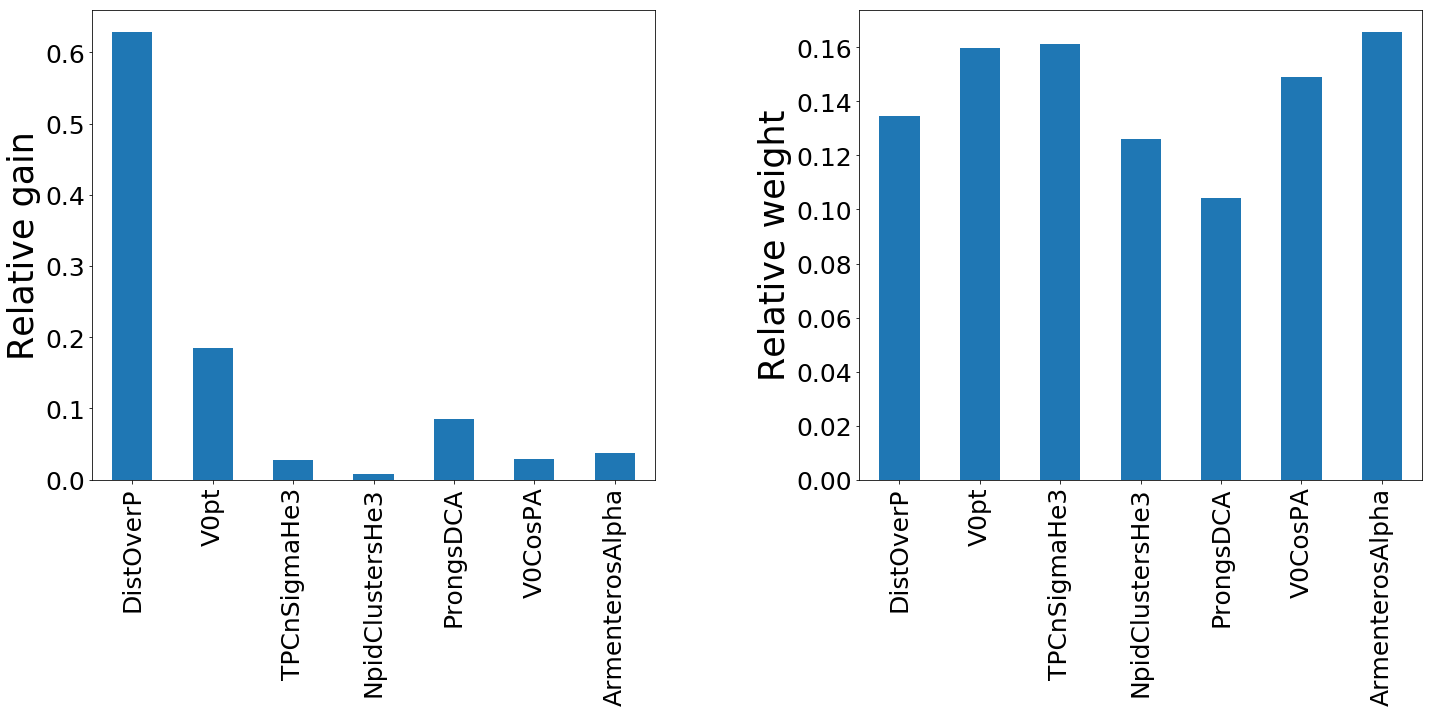

In [16]:
plot_feature_imp(model,['gain','weight'])

(1e-05, 1)

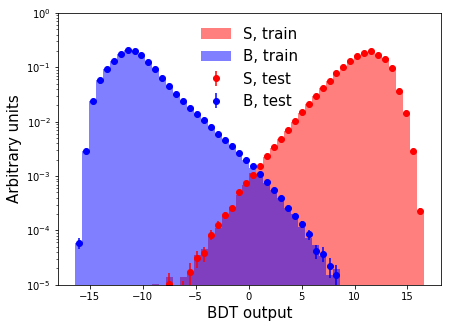

In [17]:
plot_output_train_test(model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True,log=True,location=9)
plt.ylim([10**-5,10**0])

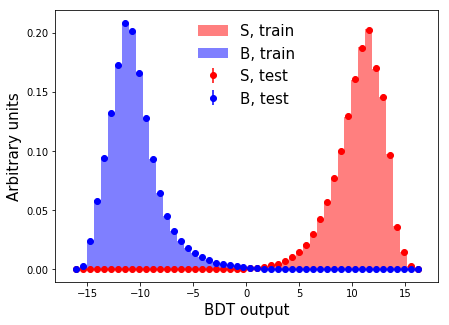

In [18]:
plot_output_train_test(model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

## BDT Efficiency 

Calcolo l'efficienza del modello in funzione dello Score.

<Figure size 432x288 with 0 Axes>

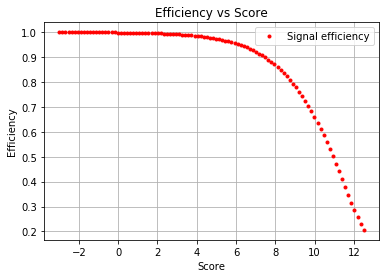

<Figure size 432x288 with 0 Axes>

In [19]:
testdata.eval('Score = @y_pred',inplace=True)
efficiency_array=EfficiencyVsCuts(testdata)
plt.figure() 

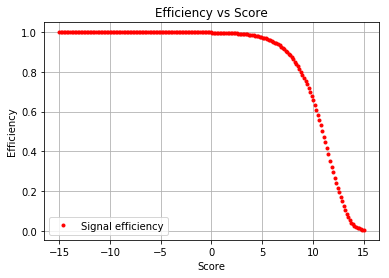

In [20]:
EfficiencyVsCuts(testdata,True)

In [21]:
np.save("efficiency_10_40_array",efficiency_array)

# Significance Scan Vs pT

Scan della Significance Vs BDT Score negli stessi bin di pT in cui Stefano ha estratto lo yield doppio differenziale per confrontare la massima sign. ottenibile con il BDT con la sign. ottenuta con il metodo standard. Eventi in classe di centralità 10-40%.

### Carico i dati  in centralità 10-40%

In [22]:
# For starting from here uncomment the model loading
df_18r = pd.read_pickle('/home/fmazzasc/HypertritonData/df_Sig_data.pkl')

df_18r = df_18r.astype('float')
df_18r = df_18r.query('10<=Centrality<=40')
# model = pickle.load(open("model_10_40.pkl", "rb"))
# efficiency_array = np.load("efficiency_10_40_array.npy", 'r')

In [23]:
df_18_1=df_18r.query('Centrality<30')
df_18_2=df_18r.query('Centrality>=30')
df_18_1['weight']=4
df_18_2['weight']=1
df_18_weighted= pd.concat([df_18_1,df_18_2])
df_18_weighted['weight']=(len(df_18r)/sum(df_18_weighted['weight']))*df_18_weighted['weight']
df_18_weighted=df_18_weighted.sample(frac=1)
del df_18_1,df_18_2

/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Funzioni di servizio

In [24]:
def SignificanceError(sig,bkg,i):
    yield_meas = [1e-5,8e-6,4e-6,9e-7]
    err_sig=np.sqrt(yield_meas[i])/(yield_meas[i])*sig
    err_bkg=sqrt(bkg)
    err_sig=sqrt(sig)
    err_1=(sqrt(sig+bkg)-sig*(1/(2*sqrt(sig+bkg))))/(sig+bkg)
    err_2=sig/(2*(sig+bkg)**(3/2))
    return abs(err_1)*err_sig+abs(err_2)*err_bkg

In [25]:
def ExpectedSignal(eff_bdt, i):
    n_ev = 20308562
    yield_meas = [1e-5,8e-6,4e-6,9e-7] # values taken from S.Trogolo PhD Thesis
    eff_V0 = [0.0819,0.1172,0.1439,0.1650] # values computed in eff2body.cc macro
    dpT = [1,1,1,4]
    return int(round(2*n_ev*yield_meas[i]*dpT[i]*eff_V0[i]*eff_bdt))

In [26]:
def SignificanceScan(df, pT_min, pT_max, i_pT,custom=False):    
    signal_array = []
    significance_array = []
    custom_significance_array = []
    error_array=[]
    score_list = np.linspace(-3,12.5,100)
    index = 0
    for i in score_list:
        df_score = df.query('Score>@i and V0pt>=@pT_min and V0pt<=@pT_max')
        counts,bins = np.histogram(df_score['InvMass'],bins=26,range=[2.97,3.05],weights=df_score['weight']);
        bin_centers = 0.5*(bins[1:]+bins[:-1])
        sidemap = (bin_centers<2.9923-3*0.0025) + (bin_centers>2.9923+3*0.0025)
        massmap = logical_not(sidemap)
        bins_side = bin_centers[sidemap]
        counts_side = counts[sidemap]
        h, residuals, _, _, _ = polyfit(bins_side,counts_side,2,full=True)
        chisq_dof = residuals / (len(bins_side) - 3)
        y = polyval(h,bins_side)
        signal = ExpectedSignal(efficiency_array[index], i_pT)
        bkg = sum(polyval(h,bin_centers[massmap]))
        significance = signal/sqrt(signal+bkg+1e-10)
        signal_array.append(signal)
        error_array.append(SignificanceError(signal,bkg,i_pT))
        significance_array.append(significance)
        custom_significance = significance*efficiency_array[index]
        custom_significance_array.append(custom_significance)
        index += 1
    significance_array=asarray(significance_array)
    error_array=asarray(error_array)
        
    if custom==True:
        max_index = np.argmax(custom_significance_array)
    else:
        max_index = np.argmax(significance_array)
        
    max_score = score_list[max_index]
    sign = significance_array[max_index]
    custom_sign = custom_significance_array[max_index]
    ryield = signal_array[max_index]
    df_cut = df.query('Score>@max_score and V0pt>=@pT_min and V0pt<=@pT_max')
    counts_mc_0 = norm.pdf(bin_centers,loc=2.992,scale=0.0025)
    counts_mc = (ryield/sum(counts_mc_0))*counts_mc_0
    counts_data,_ = np.histogram(df_cut['InvMass'],bins=26,range=[2.97,3.05],weights=df_cut['weight']);
    h = polyfit(bins_side,counts_data[sidemap],2)
    counts_bkg = polyval(h,bin_centers)
    counts_tot = counts_bkg+counts_mc
    fig, axs = plt.subplots(1,2, figsize=(12, 4)) 
    axs[0].set_xlabel('Score')
    axs[0].tick_params(axis="x", direction="in")
    axs[0].tick_params(axis="y", direction="in")
    
    
    if custom==True:
        axs[0].set_ylabel('Significance x Efficiency')
        axs[0].plot(score_list,custom_significance_array,'b',label='Expected significance')
        a=custom_significance_array-error_array*efficiency_array
        b=custom_significance_array+error_array*efficiency_array
        axs[0].fill_between(score_list,a,b,facecolor='deepskyblue',label=r'$ \pm 1\sigma$')
        axs[0].grid()
        
    else:
        axs[0].set_ylabel('Significance')
        axs[0].plot(score_list,significance_array,'b',label='Expected significance')
        a=significance_array-error_array
        b=significance_array+error_array
        axs[0].fill_between(score_list,a,b,facecolor='deepskyblue',label=r'$ \pm 1\sigma$')
        axs[0].grid()
    
    axs[0].legend(loc='upper left')
    plt.suptitle(r"%1.f $ \leq \rm{p}_{T} \leq $ %1.f, Cut Score = %0.2f, Significance/Events = %0.4f$x10^{-7}$, Significance x Efficiency = %0.2f , Raw yield = %0.2f" %(pT_min,pT_max,max_score,(sign/20308562)*1e7,custom_sign,ryield))
    
    yerr_data = sqrt(counts_data[sidemap])
    yerr_tot = sqrt(counts_tot[massmap])
    
    axs[1].errorbar(bin_centers[sidemap],counts_data[sidemap],yerr=yerr_data,fmt='.',ecolor='k',color='b',elinewidth=1.,label='Data')
    axs[1].errorbar(bin_centers[massmap],counts_tot[massmap],yerr=yerr_tot,fmt='.',ecolor='k',color='r',elinewidth=1.,label='Pseudodata')    
    axs[1].plot(bin_centers[sidemap],counts_bkg[sidemap],'g-',label='Background fit')
    x=np.linspace(2.9923-3*0.0025,2.9923+3*0.0025,1000)
    gaussian_counts=norm.pdf(x,loc=2.992,scale=0.0025)
    gaussian_counts=(ryield/sum(counts_mc_0))*gaussian_counts+polyval(h,x)
    axs[1].plot(x,gaussian_counts,'y',color='orange',label='Gaussian model')
    axs[1].set_xlabel(r"$m_{\ ^{3}He+\pi^{-}}$")
    axs[1].set_ylabel(r"Events /  $3.6\ \rm{MeV}/c^{2}$") 
    axs[1].tick_params(axis="x", direction="in")
    axs[1].tick_params(axis="y", direction="in")    
    axs[1].legend(loc=(0.37,0.47))
    plt.ylim(ymin=0)
    textstr = '\n'.join((
    r"%1.f GeV/c $ \leq \rm{p}_{T} < $ %1.f GeV/c " %(pT_min,pT_max,),
    r' Significance/Events = %0.4f$x10^{-7}$' % ((sign/20308562)*1e7, )))
    props = dict(boxstyle='round',facecolor='white', alpha=0,)
    axs[1].text(0.37, 0.95, textstr, transform=axs[1].transAxes,
        verticalalignment='top', bbox=props)
    plt.show()
    plt.savefig('fig{}.pdf'.format(i))
    return max_score

/home/fmazzasc/.local_pip/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 432x288 with 0 Axes>

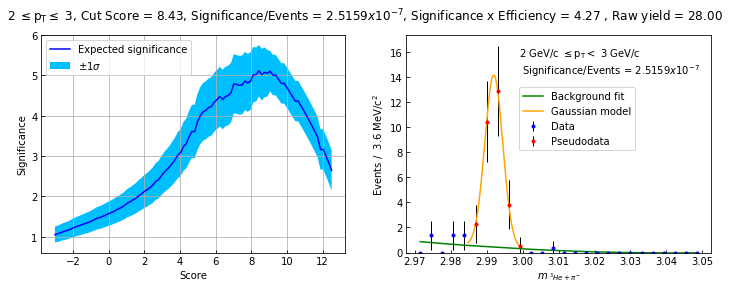

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

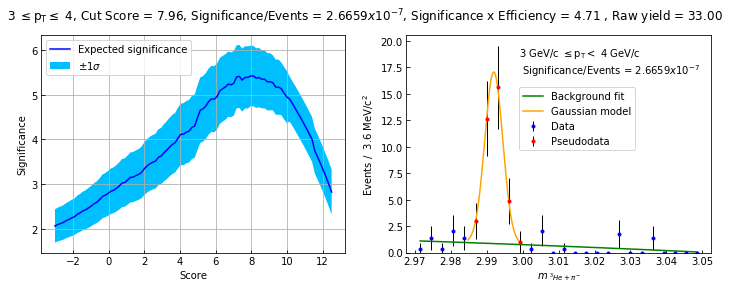

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

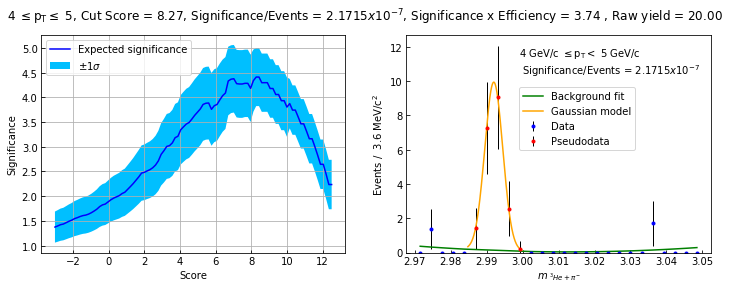

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

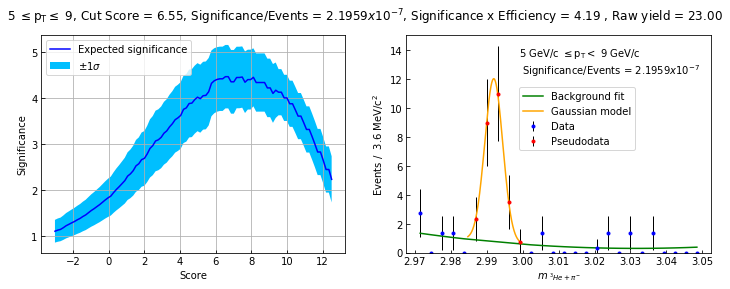

<Figure size 432x288 with 0 Axes>

In [27]:
pT_list = [[2,3],[3,4], [4,5],[5,9]]
best_score_list=[]

for i in range(0,4):
    plt.figure();
    dtest = xgb.DMatrix(data=df_18_weighted[training_columns],silent=True)
    df_18_weighted['Score'] = model.predict(dtest,output_margin=True)
    best_score_list.append(SignificanceScan(df_18_weighted,pT_list[i][0],pT_list[i][1],i))
    del dtest

<Figure size 432x288 with 0 Axes>

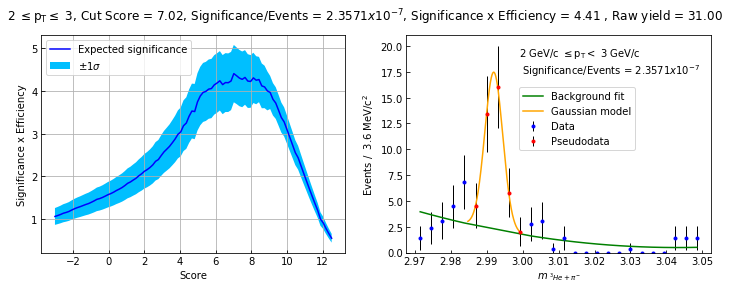

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

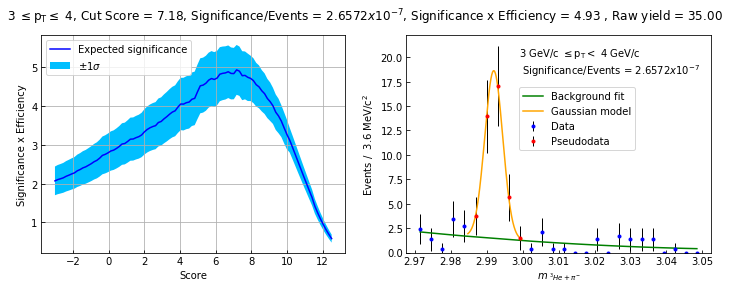

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

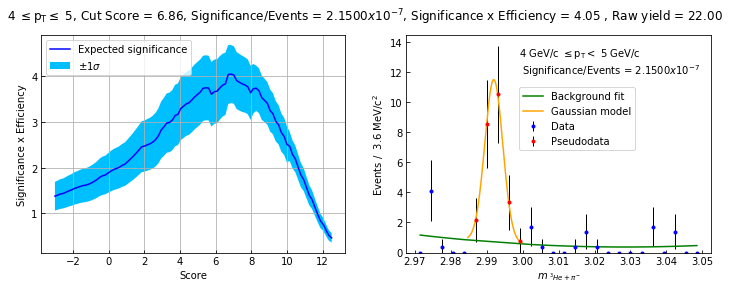

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

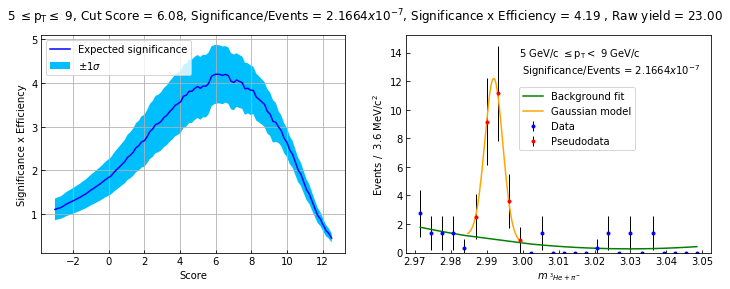

<Figure size 432x288 with 0 Axes>

In [28]:
pT_list = [[2,3],[3,4],[4,5],[5,9]]
best_score_list=[]

for i in range(0,4):
    plt.figure();
    dtest = xgb.DMatrix(data=df_18_weighted[training_columns],silent=True)
    df_18_weighted['Score'] = model.predict(dtest,output_margin=True)
    best_score_list.append(SignificanceScan(df_18_weighted,pT_list[i][0],pT_list[i][1],i,True))
    del dtest

## prova

In [29]:
def plot_distr_custom(df, column=None, **kwds):
    """Build a DataFrame and create two dataset for signal and bkg

    Draw histogram of the DataFrame's series comparing the distribution
    in `data1` to `data2`.

    X: data vector
    y: class vector
    column: string or sequence
        If passed, will be used to limit data to a subset of columns
    figsize : tuple
        The size of the figure to create in inches by default
    bins: integer, default 10
        Number of histogram bins to be used
    kwds : other plotting keyword arguments
        To be passed to hist function
    """

    data1 = df[df.y < 0.5]
    data2 = df[df.y > 0.5]

    if column is not None:
        if not isinstance(column, (list, np.ndarray, Index)):
            column = [column]
        data1 = data1[column]
        data2 = data2[column]
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    axes[0, 0].hist(data1[column[0]],bins=25,color='blue', alpha=0.5,range=[0.95,1],label='Background',density=True)
    axes[0, 0].hist(data2[column[0]],color='red', alpha=0.5,bins=25,range=[0.95,1],label='Signal',density=True)    
    axes[0, 0].set_xlabel("CosPA")
    axes[0, 0].set_ylabel("Arbitrary Units")
    axes[0,0].tick_params(axis="x", direction="in")
    axes[0,0].tick_params(axis="y", direction="in")     
    axes[0,0].legend()
    
    axes[0, 1].hist(data1[column[1]],bins=33,color='blue', alpha=0.5,range=[0,1],label='Background',density=True)
    axes[0, 1].hist(data2[column[1]],color='red', alpha=0.5,bins=33,range=[0,1],label='Signal',density=True)    
    axes[0, 1].set_xlabel("ProngsDCA")
    axes[0, 1].set_ylabel("Arbitrary Units")
    axes[0,1].tick_params(axis="x", direction="in")
    axes[0,1].tick_params(axis="y", direction="in")     
    
    axes[0, 2].hist(data1[column[2]],bins=25,color='blue', alpha=0.5,range=[0,105],label='Background',density=True)
    axes[0, 2].hist(data2[column[2]],color='red', alpha=0.5,bins=25,range=[0,105],label='Signal',density=True)    
    axes[0, 2].set_xlabel("DistOverP")
    axes[0, 2].set_ylabel("Arbitrary Units")
    axes[0,2].tick_params(axis="x", direction="in")
    axes[0,2].tick_params(axis="y", direction="in")     
    
    axes[1, 0].hist(data1[column[3]],bins=64,color='blue', alpha=0.5,range=[-1,1],label='Background',density=True)
    axes[1, 0].hist(data2[column[3]],color='red', alpha=0.5,bins=64,range=[-1,1],label='Signal',density=True)    
    axes[1, 0].set_xlabel("ArmenterosAlpha")
    axes[1, 0].set_ylabel("Arbitrary Units")
    axes[1,0].tick_params(axis="x", direction="in")
    axes[1,0].tick_params(axis="y", direction="in")    

    axes[1, 1].hist(data1[column[4]],bins=90,color='blue', alpha=0.5,range=[0,180],label='Background',density=True)
    axes[1, 1].hist(data2[column[4]],color='red', alpha=0.5,bins=90,range=[0,180],label='Signal',density=True)    
    axes[1, 1].set_xlabel("NpidClustersHe3")
    axes[1, 1].set_ylabel("Arbitrary Units")
    axes[1,1].tick_params(axis="x", direction="in")
    axes[1,1].tick_params(axis="y", direction="in")    

    axes[1, 2].hist(data1[column[5]],bins=64,color='blue', alpha=0.5,range=[0,10],label='Background',density=True)
    axes[1, 2].hist(data2[column[5]],color='red', alpha=0.5,bins=64,range=[0,10],label='Signal',density=True)    
    axes[1, 2].set_xlabel("V0pt")
    axes[1, 2].set_ylabel("Arbitrary Units")
    axes[1,2].tick_params(axis="x", direction="in")
    axes[1,2].tick_params(axis="y", direction="in")
    
    axes[2, 0].hist(data1[column[6]],bins=32,color='blue', alpha=0.5,range=[-4,4],label='Background',density=True)
    axes[2, 0].hist(data2[column[6]],color='red', alpha=0.5,bins=64,range=[-4,4],label='Signal',density=True)    
    axes[2, 0].set_xlabel("TPCnSigmaHe3")
    axes[2, 0].set_ylabel("Arbitrary Units")
    axes[2,0].tick_params(axis="x", direction="in")
    axes[2,0].tick_params(axis="y", direction="in") 

    axes[2, 1].remove()  # don't display empty ax
    axes[2, 2].remove() 



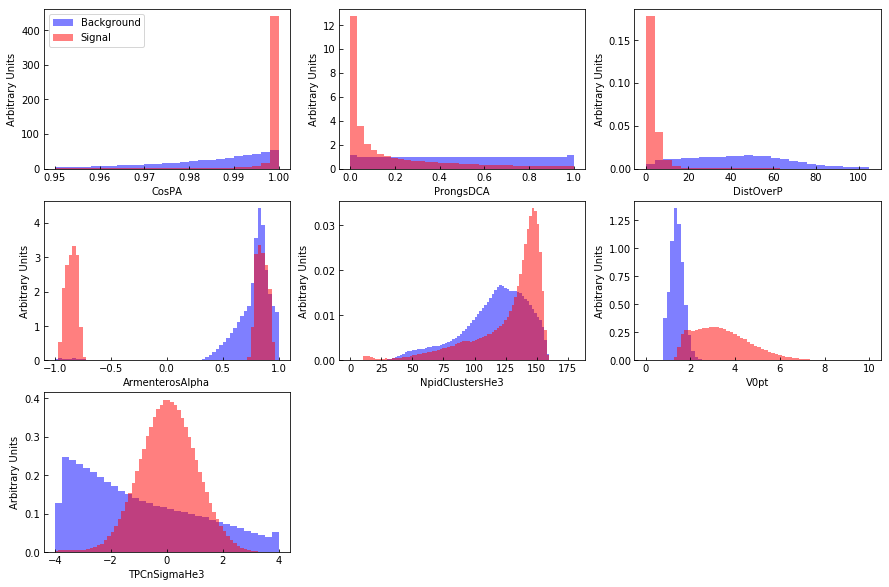

In [30]:
plot_distr_custom(df,training_columns)

###   test data

In [31]:
from scipy.optimize import curve_fit

In [32]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


In [50]:
def TestOnData(df,score,pt):
    df_score = df.query('Score>@score and V0pt>=@pt[0] and V0pt<=@pt[1]')
    counts,bins = np.histogram(df_score['InvMass'],bins=28,range=[2.97,3.05]);
    bin_centers = 0.5*(bins[1:]+bins[:-1])
    sidemap = (bin_centers<2.9923-3*0.0025) + (bin_centers>2.9923+3*0.0025)
    massmap = logical_not(sidemap)
    bins_side = bin_centers[sidemap]
    counts_side = counts[sidemap]
    h = polyfit(bins_side,counts_side,2)
    y = polyval(h,bins_side)
    counts_bkg = polyval(h,bin_centers[massmap]) 
    counts_sig=counts[massmap]-counts_bkg
    popt, pcov = curve_fit(gauss_function, bin_centers[massmap],counts_sig, p0 = [0, 2.9923, 0.0025])
    x=linspace(bin_centers[massmap][0]-0.01,bin_centers[massmap][-1]+0.01,100)
    x_bkg=polyval(h,x)
    plt.plot(x, gauss_function(x, *popt)+x_bkg,'b-')
    plt.plot(bin_centers[massmap],counts[massmap],'r.')
    plt.plot(bin_centers[sidemap],y,'g-')
    plt.plot(bin_centers[sidemap],counts[sidemap],'y.')
    print(popt)
        

In [69]:
df_18r = pd.read_pickle('/home/fmazzasc/HypertritonData/df_Sig_data.pkl')
df_18r = df_18r.astype('float')
aa = df_18r.query('Centrality<90')
dm=xgb.DMatrix(data=aa[training_columns],silent=True)
aa['Score']=model.predict(dm,output_margin=True)

[7.94091815e+01 2.99284213e+00 1.89606878e-03]


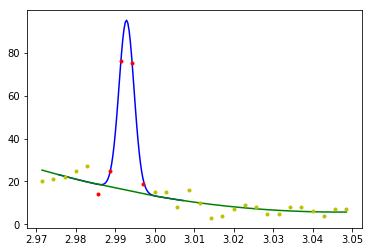

In [71]:
TestOnData(aa,8,[2,9])